*Grid searching is generally not an operation that we can perform with deep learning methods.*

*This is because deep learning methods often require large amounts of data and large models, together resulting in models that take hours, days, or weeks to train.*

*In those cases where the datasets are smaller, such as univariate time series, it may be possible to use a grid search to tune the hyperparameters of a deep learning model.*

***Objective: Discovering how to develop a framework to grid search hyperparameters for deep learning models.***

(144, 1)


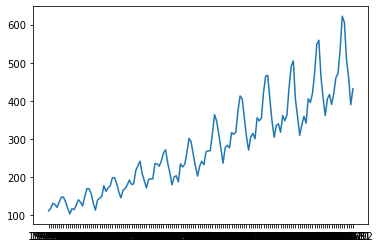

In [3]:
# load and plot dataset
# grid search persistence models for airline passengers
from math import sqrt
from numpy import mean
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
# load
series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
data = series.values
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.show()

Here, we'll not optimize the model hyperparameters for this problem. Instead, demonstrating how to grid search the deep learning model hyperparameters generally and find models with some skill compared to a naive model.

From prior experiments, a naive model can achieve a root mean squared error, or RMSE, of 50.70 (thousands of passengers) by persisting the value from 12 months ago (relative index -12).

The performance of this naive model provides a bound on a model that is considered skillful for this problem. Any model that achieves a predictive performance of lower than 50.70 on the last 12 months has skill.

It should be noted that a tuned ETS model can achieve an RMSE of 17.09 and a tuned SARIMA can achieve an RMSE of 13.89. These provide a lower bound on the expectations of a well-tuned deep learning model for this problem.

Now that we have defined our problem and expectations of model skill, we can look at defining the grid search test harness.

# Grid Search Framework

Developing a grid search test harness that can be used to evaluate a range of hyperparameters for different neural network models, such as MLPs, CNNs, and LSTMs.

## Train-Test Split

We will use the first 11 years (132 observations) for training and the last 12 for the test set.

In [4]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]


## Series as Supervised Learning

We need to be able to frame the univariate series of observations as a supervised learning problem so that we can train neural network models.

A supervised learning framing of a series means that the data needs to be split into multiple examples that the model learns from and generalizes across.

Each sample must have both an input component and an output component.

The input component will be some number of prior observations, such as three years, or 36 time steps.

The output component will be the total sales in the next month because we are interested in developing a model to make one-step forecasts.

We can implement this using the shift() function on the pandas DataFrame. It allows us to shift a column down (forward in time) or back (backward in time). We can take the series as a column of data, then create multiple copies of the column, shifted forward or backward in time in order to create the samples with the input and output elements we require.

When a series is shifted down, NaN values are introduced because we don’t have values beyond the start of the series.Rows with NaN values can be removed.

*The **series_to_supervised()** function below implements this behavior, allowing you to specify the number of lag observations to use in the input and the number to use in the output for each sample. It will also remove rows that have NaN values as they cannot be used to train or test a model.*

In [5]:
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

## Walk-Forward Validation

Time series forecasting models can be evaluated on a test set using walk-forward validation.
Walk-forward validation is an approach where the model makes a forecast for each observation in the test dataset one at a time. After each forecast is made for a time step in the test dataset, the true observation for the forecast is added to the test dataset and made available to the model.

Simpler models can be refit with the observation prior to making the subsequent prediction. More complex models, such as neural networks, are not refit given the much greater computational cost. Nevertheless, the true observation for the time step can then be used as part of the input for making the prediction on the next time step.

In [6]:
''' We will define a generic model_fit() function to perform this operation that can be 
filled in for the given type of neural network that we may be interested in later. 
The function takes the training dataset and the model configuration and returns the fit model ready for making predictions.'''

# fit a model
def model_fit(train, config):
	return None

In [7]:
'''Each time step of the test dataset is enumerated. A prediction is made using the fit model.
Again, we will define a generic function named model_predict() that takes the fit model, 
the history, and the model configuration and makes a single one-step prediction.'''

# forecast with a pre-fit model
def model_predict(model, history, config):
	return 0.0

The prediction is added to a list of predictions and the true observation from the test set is added to a list of observations that was seeded with all observations from the training dataset. This list is built up during each step in the walk-forward validation, allowing the model to make a one-step prediction using the most recent history.

All of the predictions can then be compared to the true values in the test set and an error measure calculated.We will calculate the root mean squared error, or RMSE, between predictions and the true values.

The measure_rmse() implements RMSE below using the mean_squared_error() scikit-learn function to first calculate the mean squared error, or MSE, before calculating the square root.

In [8]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

*The complete **walk_forward_validation()** function that ties all of this together is below.*

It takes the dataset, the number of observations to use as the test set, and the configuration for the model, and returns the RMSE for the model performance on the test set.

In [9]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

## Repeat Evaluation

Neural network models are **stochastic**.This means that, given the same model configuration and the same training dataset, a different internal set of weights will result each time the model is trained that will, in turn, have a different performance.

This is a benefit, allowing the model to be adaptive and find high performing configurations to complex problems.

It is also a problem when evaluating the performance of a model and in choosing a final model to use to make predictions.

To address model evaluation, we will evaluate a model configuration multiple times via walk-forward validation and report the error as the average error across each evaluation.This is not always possible for large neural networks and may only make sense for small networks that can be fit in minutes or hours.

*The **repeat_evaluate()** function below implements this and allows the number of repeats to be specified as an optional parameter that defaults to 10 and returns the mean RMSE score from all repeats.*

In [10]:
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

## Grid Search

We now have all the pieces of the framework.

All that is left is a function to drive the search. We can define a ***grid_search()*** function that takes the dataset, a list of configurations to search, and the number of observations to use as the test set and perform the search.

Once mean scores are calculated for each config, the list of configurations is sorted in ascending order so that the best scores are listed first.

In [11]:
# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores